# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Импортируем необходимые библиотеки.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install catboost

In [3]:
!pip install lightgbm

In [4]:
!pip install -U scikit-learn

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.1
    Uninstalling scikit-learn-1.2.1:
      Successfully uninstalled scikit-learn-1.2.1


In [5]:
import pandas as pd
import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder,  OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

Загрузим имеющийся датасет.

In [6]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

### Анализ данных

Проведем первоначальный анализ данных.

In [7]:
df.head(20)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Есть целевой показатель - цена автомобиля. Показатель количественный, перед нами будет стоять задача построения модели регрессии.
Есть 15 признаков, часть из которых - качественные, часть - количественные.

Проверим наличие пропусков по всей выборке.

In [9]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Проверим выборку на наличие полных дубликатов

In [10]:
df.duplicated().sum()

4

Удалим дубликаты

In [11]:
df = df.drop_duplicates().reset_index(drop = True)

Для категориальных признаков с текстовым значением проверим наличие неявных дубликатов.

In [12]:
list = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

for column in list:
    print(column)
    print(df[column].unique())
    print()

VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Gearbox
['manual' 'auto' nan]

Model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuor

Неявных дубликатов в выборке не обнаружено.

Проверим признаки на мультиколлинеарность.

In [13]:
df.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333207,0.110580,NaN,0.076058
RegistrationYear,0.026916,1.000000,-0.000828,-0.053448,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024006,0.043379,NaN,0.021662
Kilometer,-0.333207,-0.053448,0.024006,1.000000,0.009575,NaN,-0.007685
RegistrationMonth,0.110580,-0.011619,0.043379,0.009575,1.000000,NaN,0.013996
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076058,-0.003459,0.021662,-0.007685,0.013996,NaN,1.000000


Все количесвенные признаки слабо коррелируют друг с другом, проблема мультиколлинеарности не обнаружена.

Удалим столбцы с лишними признаками, которые не пригодятся для моделирования. Это следующие признаки:
- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

In [14]:
autos = df.drop(['DateCrawled', 'RegistrationMonth','DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis = 1)

### Предобработка данных. Обработка пропусков.

Проверим наличие пропущенных значений в уменьшенной выборке.

In [15]:
autos.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

  Есть пропуски в следующих столбцах: 
- VehicleType - тип автомобильного кузова
- Gearbox - тип коробки передач
- Model - модель автомобиля
- FuelType -тип топлива
- Repaired - была машина в ремонте или нет

Посмотрим на значения в каждом из столбцов, где присутствуют пропуски.

In [16]:
list = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']

for column in list:
    print(autos[column].value_counts())
    print()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

manual    268249
auto       66283
Name: Gearbox, dtype: int64

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

no     247158
yes     36053
Name: Repaired, dtype: int64



Пропуски в столбце Repaired (была машина в ремонте или нет заменим на "no"), остальные пропуски   сложно заменить какими-либо подходящими по смыслу значениями, которые не будут искажать распределение в выборке, поэтому эти пропуски заменим на значение "unknown".

In [17]:
autos['Repaired'] = autos['Repaired'].fillna('no')

In [18]:
for column in ['VehicleType', 'Gearbox', 'Model', 'FuelType']:
    autos[column] = autos[column].fillna('unknown')

Проверим заполнение пропусков

In [19]:
autos.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

### Предобработка данных. Обработка аномалий.

Посмотрим на описательную статистику по количественным признакам в выборке.

In [20]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


В столбцах Price, RegistrationYear и Power есть выбросы, их необходимо обработать. Начнем с целевого значения - цены автомобиля. Построим гистограмму распределения, посмотрим на выбросы.

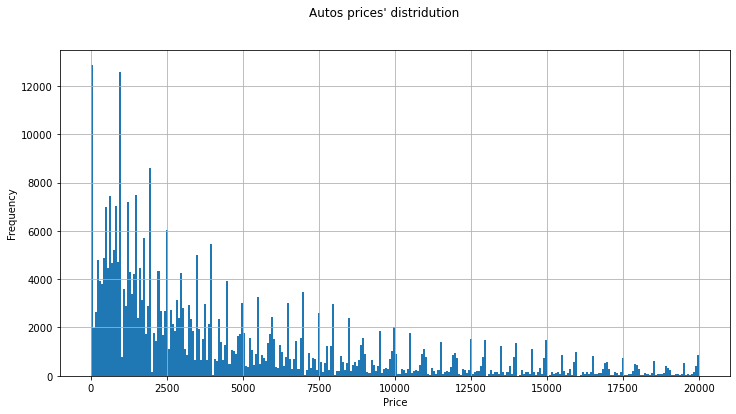

In [21]:
autos['Price'].hist(figsize =(12,6), bins = 300)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.suptitle("Autos prices' distridution")
plt.show()

Удалим нулевые значения.

In [22]:
count_zeros = autos[autos['Price']==0]['Price'].count()
print('Всего нулевых значений в столбце Price :', count_zeros )
print(f'В процентном соотношении ко всему размеру выборки это составляет: {count_zeros/autos.shape[0]:.3%}')

Всего нулевых значений в столбце Price : 10772
В процентном соотношении ко всему размеру выборки это составляет: 3.040%


In [23]:
autos =  autos[autos['Price']>0].reset_index(drop=True)

Обработаем аномалии в столбце RegistrationYear

In [24]:
autos['RegistrationYear'].value_counts()

2000    23072
1999    21994
2005    21524
2006    19679
2001    19653
        ...  
3800        1
4800        1
6500        1
2290        1
1946        1
Name: RegistrationYear, Length: 140, dtype: int64

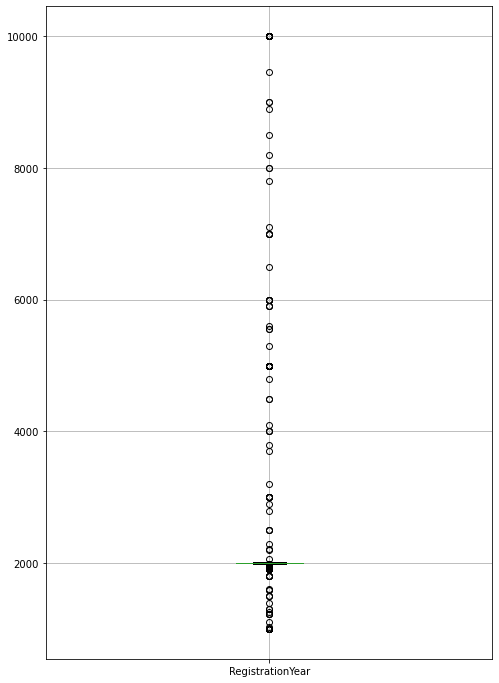

In [25]:
autos.boxplot(column='RegistrationYear', figsize=(8,12))
plt.show()

Судя по диаграмме размаха, есть много значений за возможными рамками. Определим максимальное значение года регистрации автомобиля как самый поздний год, в который были скачана анкета (значение года в признаке DateCrawled). За крайнюю левую границу возьмем год выпуска первого автомобиля (1886 год).

In [26]:
max_year = pd.to_datetime(df['DateCrawled']).max().year
max_year

2016

In [27]:
count_years = autos.query('(RegistrationYear < 1886)|(RegistrationYear > @max_year)').shape[0]
print('Всего аномальных значений признака RegistrationYear:', count_years )
print(f'В процентном соотношении ко всему размеру выборки это составляет: {count_years/autos.shape[0]:.3%}')

Всего аномальных значений признака RegistrationYear: 13832
В процентном соотношении ко всему размеру выборки это составляет: 4.026%


Очистим выборку от аномальных значений и посмотрим на гистограмму распределения.

In [28]:
autos = autos.query('1886<=RegistrationYear<=@max_year').reset_index(drop=True)

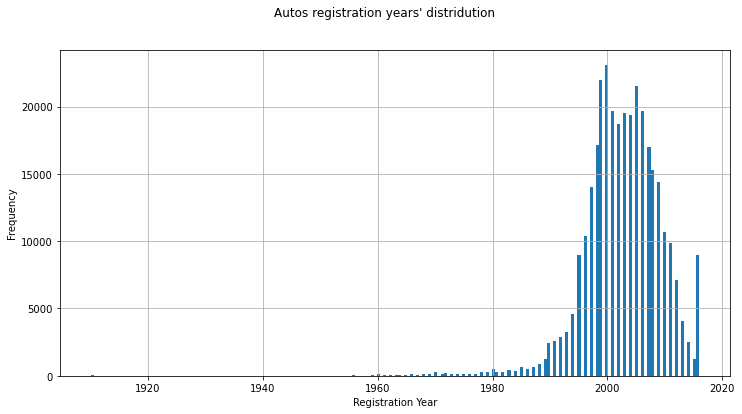

In [29]:
autos['RegistrationYear'].hist(figsize =(12,6), bins = 200)
plt.xlabel('Registration Year')
plt.ylabel('Frequency')
plt.suptitle("Autos registration years' distridution")
plt.show()

Обработаем выбросы в значениях признака Power — мощность (л. с.)
Самая мощная машина в 2017 году имеет двигатель мощностью 1244 л.с. (выберем этот значение за правую границу диапазона), также уберем нулевые значения.

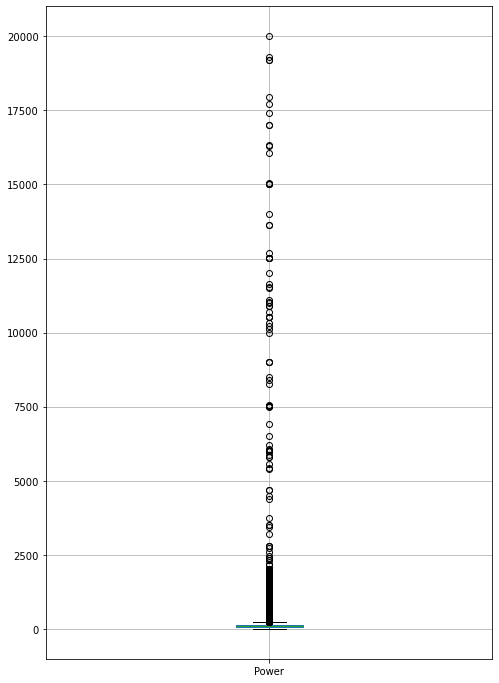

In [30]:
autos.boxplot(column='Power', figsize=(8,12))
plt.show()

In [31]:
count_power = autos.query('(Power == 0)|(Power > 1244)').shape[0]
print('Всего аномальных значений признака RegistrationYear:', count_power )
print(f'В процентном соотношении ко всему размеру выборки это составляет: {count_power/autos.shape[0]:.3%}')

Всего аномальных значений признака RegistrationYear: 33079
В процентном соотношении ко всему размеру выборки это составляет: 10.031%


In [32]:
autos = autos.query('0 < Power <= 1244').reset_index(drop=True)

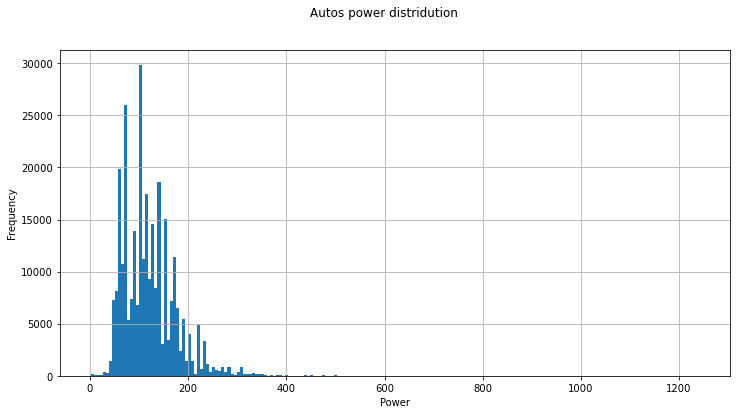

In [33]:
autos['Power'].hist(figsize =(12,6), bins = 200)
plt.xlabel('Power')
plt.ylabel('Frequency')
plt.suptitle("Autos power distridution")
plt.show()

Выборка очищена от выбросов. Посмотрим, какова потеря данных в процентном соотношении.

In [34]:
loss= df.shape[0]/autos.shape[0] - 1
print(f'Потеря данных после очистки то аномальных значений составила: {loss: .3%}')
print('Размер очищенной от выбросов выборки:',autos.shape[0])

Потеря данных после очистки то аномальных значений составила:  19.443%
Размер очищенной от выбросов выборки: 296682


Потеря данных существенная,однако в данном случае она оправдана, поскольку оставшаяся выборка достаточно большая и наиболее репрезентативная для дальнейшего построения модели с высокими показателями качества.

<b> ВЫВОД: </b>

На первоначальном этапе исследования выполнены следующие шаги:
- проведен исследовательский анализ имеющихся данных
- осуществлена предобработка выборки, включающая в себя заполнение пропусков, проверку данных на наличие явных и неявных дубликатов, устранение выбросов в количественных признаках

Сделаны следующие значимые выводы:
- Выборка состоит из качественных и количественных признаков, целевой показатель - цена автомобиля, является количественным (перед нами задача регрессии)
- Данные не содержат сильно коррелирующих между собой признаков, проблема мультиколлинеарности не обнаружена
- Есть пропуски, которые заменены подходящими по смыслу значениями или "заглушкой"
- Удалены полные дубликаты
- НЕявные дубликаты не обнаружены
- В количественных данных есть аномальные значения. После очистки выборки от выбросов было удалено 19.4% данных.

Выборка готова к моделированию.

## Обучение моделей

Выделим признаки и целевой показатель.

In [35]:
features = autos.drop(['Price'], axis = 1)
target = autos['Price']

Разделим выборку на обучающую и тестовую в соотношении 75% : 25%

In [36]:
features_train, features_test, target_train, target_test = train_test_split(features, target,test_size=0.25, random_state = 123)

Разделим признаки на категориальные и количественные.

In [37]:
category = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
numeric = ['RegistrationYear', 'Power', 'Kilometer']

Результаты интересующих метрик будем помещать в список results_model.`

In [38]:
results_model = []

Попробуем построить четыре различные модели:
   - CatBoost
   - LightGBM
   - Ridge
   - RandomForestRegressor

Подберем гиперпараметры, все полученнные результаты по лучшим моделям запомним с целью дальнейшего сравнения и выбора наилучшей.

### CatBoost

In [ ]:
%%time

model = CatBoostRegressor(cat_features = category, verbose = False, random_state = 123)

params = { 'iterations': [50, 70, 100],
            'learning_rate': [0.1, 0.2],
            'depth': [4, 10]}

cat_boost = GridSearchCV(model, params, cv=5, scoring='neg_root_mean_squared_error', n_jobs = -1)
cat_boost.fit(features_train, target_train)
cat_boost_best = cat_boost.best_estimator_

print('Наилучшая модель CatBoost:', cat_boost.best_params_)
print(f'RMSE_cat_boost = {abs(cat_boost.best_score_).round(3)}')

Посмотрим, как распределяются признаки по важности в самой лучшей модели типа CatBoost.

In [ ]:
feature_importances = pd.Series(cat_boost_best.feature_importances_, index=features_train.columns)
print(feature_importances)
feature_importances.nlargest(10).plot(figsize = (8,6), kind='bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.suptitle("Feature importances in CatBoost best model")
plt.show()

Наиболее значимыми признаками для модели являются год регистрации, мощность и брэнд.

Время обучения и время получения предсказаний наилучшей модели каждого вида будем брать из cv_results_.
Для упрощения кода создадим функцию.

In [ ]:
def get_time(grid):
    grid_results = pd.DataFrame(grid.cv_results_)
    fit_time = grid_results[grid_results['rank_test_score']==1]['mean_fit_time'].values[0]
    predict_time = grid_results[grid_results['rank_test_score']==1]['mean_score_time'].values[0]
    return grid_results, fit_time, predict_time


In [ ]:
get_time(cat_boost)[0]


Добавим полученнные результаты наилучшей модели cat_boost к списку results_model. Будем делать это для каждого типа модели в дальнейшем.

In [ ]:
results_model.append({'model': 'CatBoost',
                      'RMSE': abs(cat_boost.best_score_).round(3),
                      'fitting_time': (get_time(cat_boost)[1]).round(3),
                      'predicting_time': (get_time(cat_boost)[2]).round(3)})


### LightGBM

Используем внутренний механизм кодирования категориальных признаков для модели LightGBM. 
Для этого предварительно переведем категориальные признаки в тип 'category'.

In [ ]:
%%time

features_train_lgbm = features_train.copy()

features_train_lgbm[category] = features_train[category].astype('category')

model = LGBMRegressor(random_state = 123)

params = { 'max_depth': [7, 10],
           'learning_rate': [0.1, 0.15],
           'n_estimators': [50, 70, 90]}

lgbm  = GridSearchCV(model, params, cv=5, scoring='neg_root_mean_squared_error')
lgbm.fit(features_train_lgbm, target_train)
lgbm_best = lgbm.best_estimator_

print('Наилучшая модель LightGBM:', lgbm.best_params_)
print(f'RMSE_lgbm = {abs(lgbm.best_score_).round(3)}')


Посмотрим, как распределяются признаки по важности в самой лучшей модели типа LightGBM.

In [ ]:
feature_importances = pd.Series(lgbm_best.feature_importances_, index=features_train_lgbm.columns)
print(feature_importances)
feature_importances.nlargest(10).plot(figsize = (8,6), kind='bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.suptitle("Feature importances in LightGBM best model")
plt.show()

Интересно, что для LightGBM наиболее значимыми являются признаки модель, год регистрации и мощность (есть отличия по сравнению с CatBoost).

In [ ]:
get_time(lgbm)[0]

In [ ]:
results_model.append({'model': 'LightGBM',
                      'RMSE': abs(lgbm.best_score_).round(3),
                      'fitting_time': (get_time(lgbm)[1]).round(3),
                      'predicting_time': (get_time(lgbm)[2]).round(3)})


### Ridge

In [ ]:
# Попробуем использовать линейную модель Ридж регрессии.
# Для кодирования категориальных признаков будем использовать OneHotEncoder
# для масштабирования количественных StandardScaler

# для кодирования и масштабирования будем использовать make_column_transformer, потом включая его в pipeline

In [ ]:
%%time
features_train_ridge = features_train.copy()


transformer_ridge = make_column_transformer(
                   (OneHotEncoder(drop='first', handle_unknown='ignore'), category),
                   (StandardScaler(), numeric)
                                            )

model_ridge = Ridge(random_state = 123)
pipe = make_pipeline(transformer_ridge, model_ridge)

params = {'ridge__alpha': np.arange(0, 2, 0.2)}

ridge_model = GridSearchCV(pipe, params, scoring = 'neg_root_mean_squared_error', cv=5, n_jobs = -1)
ridge_model.fit(features_train_ridge, target_train)
ridge_model_best = ridge_model.best_estimator_

print('Наилучшая модель Ridge:', ridge_model.best_params_)
print(f'RMSE_ridge = {abs(ridge_model.best_score_).round(3)}')

In [ ]:
get_time(ridge_model)[0]

In [ ]:
results_model.append({'model': 'Ridge',
                     'RMSE': abs(ridge_model.best_score_).round(3),
                      'fitting_time': (get_time(ridge_model)[1]).round(3),
                      'predicting_time': (get_time(ridge_model)[2]).round(3)})

### RandomForestRegressor

In [ ]:
# Используем модель случайного леса на имеющихся данных.
# для кодирования категориальных признаков (кроме Model) будем использовать OneHotEncoder 
# и OrdinalEncoder для кодирования признака Model (там наибольшее количество значений)

# для масштабирования количественных - StandardScaler

# для кодирования и масштабирования будем использовать make_column_transformer, который потом включается в pipeline

# для подбора оптимальных гиперпараметров будем использовать RandomizedSearchCV (с целью ускорения работы кода)

In [ ]:
%%time
features_train_rf = features_train.copy()

ohe_rf = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']
oe_rf = ['Model']

transformer_rf = make_column_transformer(
                         (OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_rf),
                         (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1), oe_rf),
                         (StandardScaler(), numeric)
                                          )

model_rf = RandomForestRegressor(random_state = 123)
pipe_rf = make_pipeline(transformer_rf, model_rf)

params =  {'randomforestregressor__n_estimators': range(30, 80, 5), 
           'randomforestregressor__max_depth': [3, 5]}

rf = RandomizedSearchCV(pipe_rf, params, scoring = 'neg_root_mean_squared_error', cv=5, n_jobs = -1, random_state = 123)
rf.fit(features_train_rf, target_train)
rf_best =  rf.best_estimator_

print('Наилучшая модель RandomForest:', rf.best_params_)
print(f'RMSE_random_forest = {abs(rf.best_score_).round(3)}')

In [ ]:
get_time(rf)[0]

In [ ]:
results_model.append({'model': 'RandomForest',
                      'RMSE': abs(rf.best_score_).round(3),
                      'fitting_time': (get_time(rf)[1]).round(3),
                      'predicting_time': (get_time(rf)[2]).round(3)})

 <b> Вывод:</b> 
 
 На данном этапе проведено моделирование с использованием 4 типов моделей:
 - CatBoost
 - LightGBM
 - Ridge
 - RandomForestRegressor

Для каждой модели осуществлен поиск гиперпараметов с помощью GridSearchCV и RandomizedSearchCV: методов поиска со встренной кросс-валидалицией. Для каждой модели удалось перебрать 2-3 гиперпараметра.

Интересующие нас метрики работы модели: RMSE, время обучения модели и время предсказания сохранены в отдельном датафрейме. 

На следующем этапе проведем сравнение построенных моделей, выберем наилучшую и проверим ее на тестовой выборке.

## Анализ моделей

Сравним полученные результаты интересующих метрик по каждой из моделей.

In [ ]:
results_model = pd.DataFrame(results_model)
results_model

По всем интересующим нас метрикам "выигрывает" модель LightGBM. Проверим ее на тестовой выборке.

In [ ]:
print('Модель, которая показала наилучшие результаты:')
print(lgbm_best)

print('Время обучения модели:', (get_time(lgbm)[1]).round(3))

#обучаем модель и преобразуем тестовую выборку
lgbm_best.fit(features_train_lgbm, target_train)
features_test_lgbm = features_test.copy()
features_test_lgbm[category] = features_test[category].astype('category')

# подсчитаем RMSE на тестовой выборке и засечем время предсказаний модели
start = time.time()
predictions_lgbm = lgbm_best.predict(features_test_lgbm)
end = time.time() - start
print(f'Время формирования предсказаний: {end:.3}')

rmse_test = mean_squared_error(target_test, predictions_lgbm, squared=False)
print(f'RMSE модели на тестовой выборке: {rmse_test.round(3)}')


<b> ВЫВОД: </b>

На конечном этапе исследования проведено сравнение построенных ранее регрессионных моделей.
По качеству предсказания (RMSE) значительно выигрывают модели градиентного бустинга (CatBoost и LightGBM).
Однако если сравнивать время обучения и предсказания, то можно сделать однозначный выбор в пользу модели LightGBM.

На тестовых данных выбранная модель показала хороший результат по метрике RMSE. Она составила 1591, что чуть ниже, чем на обучающей выборке. При этом увеличилось время формирования предсказаний.

В целом, построенная модель адекватна поставленной задаче.

## Итоговый вывод

Целью исследования было построение модели регрессии для предсказания цены автомобиля будущих клиентов заказчика.

Модель регресии должна быть выбрана на основе:
- качества предсказания (RMSE)
- скорости предсказания
- время обучения

В ходе проекта:
   - проанализированы имеющиеся данные, выявлены закономерности
   - осуществлена предобработка данных: заполнение пропусков, удаление дубликатов, устранение выбросов
   - построены 4 модели регресии, все они проанализированы на основании заданных метрик
   - выбрана наиболее адекватная поставленной задаче модель, ей оказалась модель LightGBM с подобранными гиперпараметрами
   - осуществлена проверка модели на тестовых данных
   - получены результаты, удовлетворяющие поставленным задачам.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей